In [1]:
# from collections import defaultdict
import numpy as np
import thinkstats2
import thinkplot
import pandas
import brfss
import math
# import nsfg

# 07. 变量之间的关系
本章中，我们将研究变量之间的关系。如果能够从一个变量的信息中得到另一个变量的信息，那么这两个变量就是相关的。例如，身高和体重是相关的，个子高的人一般体重也会比较重。当然，身高和体重的关系并不是绝对的，也有矮个的胖子和高个的瘦子。但是在猜测一个人的体重时，如果已知身高的话，进行推测会更加准确。

本章代码位于`scatter.py`中。

## 7.1 散点图
研究两个变量之间关系的最简单方法是`散点图`（scatter plot）。下面将绘制BRFSS（参见`5.4节`）调查参与者的体重与身高关系的散点图：

In [2]:
df = brfss.ReadBrfss("datasets/CDBRFS08.ASC.gz")
sample = thinkstats2.SampleRows(df, 5000)
heights, weights = sample.htm3, sample.wtkg2

SampleRows选出这些数据的一个随机子集：
```python
def SampleRows(df, nrows, replace=False):
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample
```

其中，`replace`是一个布尔值，指定采样过程是否放回，也就是说，同一列是否可以被多次选中。

thinkplot提供`Scatter`方法绘制散点图：

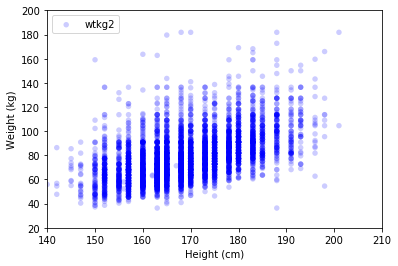

<Figure size 576x432 with 0 Axes>

In [3]:
thinkplot.Scatter(heights, weights)
thinkplot.Show(xlabel='Height (cm)', ylabel='Weight (kg)', axis=[140, 210, 20, 200])

结果显示个子高的人体重更重。

这个绘制结果的展现效果并不理想，因为数据都成列聚集。之所以产生这个现象，是因为身高数据四舍五入到相邻的英寸，转换为厘米后，再次四舍五入。在这个转换过程中，丢失了一些信息。

我们无法找回已丢失的信息，但可以将数据进行`抖动`（jittering），即加入随机噪音弥补四舍五入的效果，以减少丢失信息对散点图的影响。这些测量数据都四舍五入到相邻的英寸，因此导致的偏差可能达到0.5英寸（或1.3厘米）。同样，体重数据的偏差最大可能达到0.5千克。

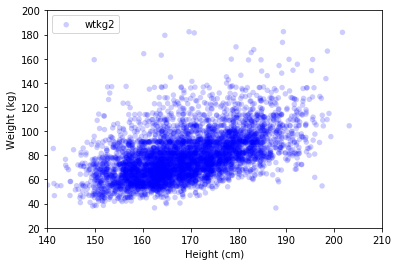

<Figure size 576x432 with 0 Axes>

In [4]:
heights = thinkstats2.Jitter(heights, 1.3)
weights = thinkstats2.Jitter(weights, 0.5)

thinkplot.Scatter(heights, weights)
thinkplot.Show(xlabel='Height (cm)', ylabel='Weight (kg)', axis=[140, 210, 20, 200])

Jitter方法的具体实现如下：
```python
def Jitter(values, jitter=0.5):
    n = len(values)
    return np.random.uniform(-jitter, +jitter, n) + values
```

上图展示了抖动处理之后的绘制结果。抖动使变量关系的形状更加清晰。

> 注意：抖动数据通常只应用于视觉效果，你应该避免在分析时使用经过抖动处理的数据。

散点图也不是展示数据的最佳方法，图中有很多重叠的点，遮盖了密集部分的数据，使离群值显得特别突出。这种效果称为`饱和`（saturation）。

我们可以使用参数`alpha`解决这个问题，将图中的点显示为半透明的：

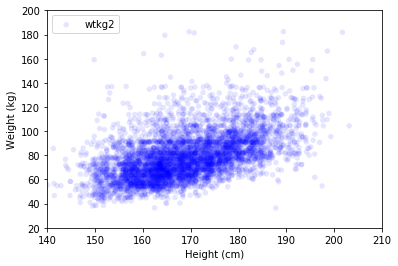

<Figure size 576x432 with 0 Axes>

In [5]:
thinkplot.Scatter(heights, weights, alpha=0.1)
thinkplot.Show(xlabel='Height (cm)', ylabel='Weight (kg)', axis=[140, 210, 20, 200])

上图展示了绘制结果。重叠的数据点颜色较深，颜色的深度与数据的密集程度成正比。图中有两个新的细节：竖直方向上，数据点汇集在几个高度周围；接近90千克（或200磅）处有一条水平线。这些数据是调查参与者自己提供的，单位为磅，因此很有可能是因为一些参与者提供了四舍五入的数据从而导致这些现象。

对于中等规模的数据集，在散点图中设置透明度效果很好。

要处理规模更大的数据集(BRFSS数据有414509条)，可以使用`hexbin`图。`hexbin`图将图像划分为六角形的区间，将每个区间按照其中数据点的数量进行着色。thinkplot提供`HexBin`方法：

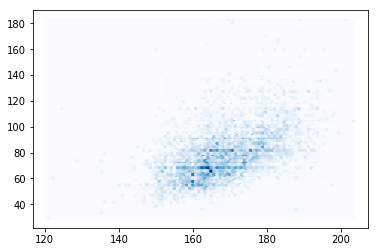

In [6]:
thinkplot.HexBin(heights, weights)

`hexBin`绘制结果很好地展示变量关系的形状，并且对于大数据集运行效率（时间效率和生成的文件大小）很高。缺点是离群值在图中不可见。

从这个示例我们可以看出，要绘制一个既能清晰展示变量关系，又不产生误导效果的散点图，并非易事。

## 7.2 描述关系特征
散点图能让我们对变量关系有个大体了解，而其他可视化方法则可以让我们更深入地了解变量关系的本质。一种方法是对一个变量进行分区，绘制另一个变量的百分位数。

`NumPy`和`pandas`都提供数据分区函数：

In [7]:
df = df.dropna(subset=['htm3', 'wtkg2'])
bins = np.arange(135, 210, 5)
indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)

`dropna`去除指定列含有`nan`值的数据行。`arrange`产生一个`NumPy`区间数组，范围为从135（不含）到210，增量为5。

`digitize`计算出`df.htm3`中每个值所属区间的索引，结果为一个包含整数索引值的`NumPy`数组。如果值小于最低区间，则索引为0；如果值大于最高区间，则索引为`len(bins)`。

`groupby`是一种`DataFrame`方法，返回一个`GroupBy`对象。当用在`for`循环中时，`groups`遍历其中的组名，以及代表各组的`DataFrame`对象。因此，我们可以打印出每组中的行数。

In [8]:
for i, group in groups:
    print(i, len(group))
    # print(group)

0 305
1 228
2 477
3 2162
4 18759
5 45761
6 70610
7 72138
8 61725
9 49938
10 43555
11 20077
12 7784
13 1777
14 405
15 131


对每个组，我们可以计算其身高均值和体重CDF：

In [9]:
heights = [group.htm3.mean() for i, group in groups]
cdfs = [thinkstats2.Cdf(group.wtkg2) for i, group in groups]

绘制身高对应的体重百分位数：

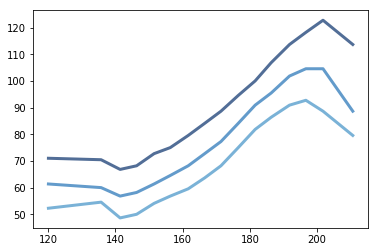

In [10]:
for percent in [75, 50, 25]:
    weights = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(heights, weights, label=label)

在140~200厘米之间，变量关系几乎是线性的。140~200厘米这个范围涵盖了超过99%的数据，因此我们无需对极端值过多考虑。

## 7.3 相关性
`相关性`（correlation）是一个统计量，用于量化两个变量之间关系的强弱。

度量相关性的困难之处在于，我们需要比较的变量通常使用不同的单位。即便变量使用相同的单位，也可能来自不同的分布。

这些问题有两个常见的解决方法：
+ 将每个值都转换为`标准分数`（standard score），即其偏离均值的标准差数。这种转换会产生`Pearson乘积矩相关系数`
+ 将每个值都转换为`秩`，即其在所有值的排序列表中的索引。这种转换会产生`Spearman秩相关系数`

假设$X$由$n$个值$x_i$构成，将每个值减去均值，然后除以标准差，即可得到标准分数：
+ $\displaystyle z_i = \frac{(x_i - \mu)}{\sigma}$

公式中的分子是一个`偏差`，即到均值的距离。除以$\sigma$可以将`偏差标准化`（standardize），因此$Z$的值是`无量纲`（无单位）的，其分布的均值为$0$，方差为$1$。

如果$X$符合正态分布，那么$Z$也符合正态分布。但如果$X$是偏斜的或包含离群值，那么$Z$也会偏斜或包含离群值。在这种情况下，使用百分位秩的稳健性更好。如果计算一个新变量$R$，使$x_i$为$x_i$的秩，那么无论$X$的分布如何，$R$总是从$1$到$n$的均匀分布。

## 7.4 协方差
`协方差`（covariance）可以度量两个变量共同变化的趋势。如果我们有两个序列$X$和$Y$，那么序列中的值与均值的偏差分别为：
+ $dx_i=x_i-\bar x$
+ $dy_i=y_i-\bar y$

其中，$\bar x$是$X$的样本均值，$\bar y$是$Y$的样本均值。如果$X$和$Y$共同变化，那么这些偏差的正负性也会相同。

将这两组偏差相乘，如果偏差的正负性相同，那么乘积就是正数；如果偏差的正负性相反，那么乘积就是负数。因此，将这些乘积累加，就可以度量两组值共同变化的趋势。

协方差是这些乘积的均值。
+ $\displaystyle \rm Cov(X, Y)=\frac{1}{n}\sum d x_i d  y_i$

其中，$n$为这两个序列的长度（两个序列的长度必须相等）。

如果你学习过线性代数，可能会发现$\rm Cov$是两组偏差的点乘积除以其长度。因此，如果两个向量相同，则协方差值最大；如果两个向量正交，则协方差为0；如果两个向量方向相反，则协方差为负数。`thinkstats2`使用`np.dot`有效地实现了$\rm Cov$算法：

```python
def Cov(xs, ys, meanx=None, meany=None):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    if meanx is None:
        meanx = np.mean(xs)
    if meany is None:
        meany = np.mean(ys)

    cov = np.dot(xs-meanx, ys-meany) / len(xs)
    return cov
```



默认情况下，$\rm Cov$计算各点到样本均值的偏差，或者你也可以提供已知的均值。协方差的这个实现版本非常简单，易于解释。`NumPy`和`pandas`也提供协方差的实现，但都用到了对小样本的矫正，而我们还未介绍过这部分知识。而且，`np.cov`返回的是协方差矩阵，对我们目前而言过于复杂了。

## 7.5 Pearson相关性
协方差在一些计算中非常有用，但其含义很难解释，因此人们很少将协方差作为摘要统计量。比如，协方差的单位是$X$和$Y$的单位乘积，这一点就很难理解。

解决这个问题的方法之一是将偏差除以标准差，得到标准分数，然后计算标准分数的乘积：
+ $\displaystyle p_i=\frac{(x_i-\bar x)}{S_X}\frac{(y_i-\bar y)}{S_Y}$

其中$S_X$和$S_Y$分别是$X$和$Y$的标准差。这些乘积的均值为：
+ $\rho=\frac{1}{n}\sum p_i$

或者，我们可以通过分解 SX 和 SY 改写标准差：
+ $\rho=\frac{\rm Cov(X, Y)}{S_XS_Y}$

这个公式以一位很有影响力的统计学家`Karl Pearson`的名字命名，称为`Pearson相关性`（Pearson's correlation）。Pearson相关性容易计算，也易于解释。因为标准分数是`无量纲`（无单位），所以$\rho$也是无单位的。

`thinkstats2`中的Pearson相关性实现代码如下：
```python
def Corr(xs, ys):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    meanx, varx = MeanVar(xs)
    meany, vary = MeanVar(ys)

    corr = Cov(xs, ys, meanx, meany) / math.sqrt(varx * vary)
    return corr
```

`Pearson相关性`取值介于$-1 ~ +1$之间（包含端点）。如果$\rho$是正数，那么我们可以说两个变量正相关，即当一个变量值较大时，另一个变量的值也会较大。如果$\rho$是负数，那么变量负相关，因此当一个变量值较大时，另一个变量值较小。

$\rho$的大小表明了相关性的强弱程度。如果$\rho$为1或-1，两个变量完全相关，也就是说，如果你知道一个变量的值，就可以对另一个变量的值进行准确的预测。

现实世界中的大部分相关性都不是完全的，但相关性依然有其作用。身高和体重的相关性为$0.51$，比起其他与人类相关的变量，身高和体重具有很强的相关性。

In [11]:
thinkstats2.Corr(df.htm3, df.wtkg2)

0.5087364789734768

## 7.6 非线性关系
如果`Pearson相关性`接近0，你可能会认为变量之间没有关系，但这个结论并不成立。`Pearson相关性`只度量了`线性关系`。如果变量之间存在非线性关系，那么$\rho$对变量相关性强弱的估计就可能是错误的。

`图7-4`摘取自[Wikipedia](http://wikipedia.org/wiki/Correlation_and_dependence)，展示了几个精心设计的数据集的散点图和相关系数：

<img src="images/07_04.png" style="width:500px;"/>

+ 第1行展示了具有不同线性相关性的数据集。你可以从这一行直观感受不同$\rho$值的相关性是怎样的
+ 第2行展示了具有不同`斜度`的完全相关，说明相关性与`斜度`无关
+ 第3行展示的变量明显具有相关性，但因为变量之间的关系是非线性的，因此协方差为0

因此，在盲目计算协方差之前，我们首先应该查看数据的散点图，以免得出错误的结论。

## 7.7 Spearman秩相关
如果变量之间的关系是线性的，而且变量大致符合正态分布，那么`Pearson相关性`能够很好地说明相关性的强弱。但是离群值会影响`Pearson相关性`的稳健性。`Spearman秩相关`能够缓解离群值以及偏斜分布的的影响，也可以用于描述变量的相关性。要计算`Spearman相关性`，必须计算每个值的`秩`（rank），即该值在排序样本中的索引。例如，在样本`[1, 2, 5, 7]`中，值5出现在排序列表的第3位，因此秩为3。

`thinkstats2`提供了一个计算`Spearman秩相关`的函数：

```python
def SpearmanCorr(xs, ys):
    xranks = pandas.Series(xs).rank()
    yranks = pandas.Series(ys).rank()
    return Corr(xranks, yranks)
```

也可以直接使用`Series.corr`方法，在参数中指定使用`Spearman方法`：
```python
def SpearmanCorr(xs, ys):
    xranks = pandas.Series(xs)
    yranks = pandas.Series(ys)
    return xs.corr(ys, method='spearman')
```

In [12]:
df.htm3.corr(df.wtkg2, method='spearman')

0.5405846262320483

In [13]:
thinkstats2.SpearmanCorr(df.htm3, df.wtkg2)

0.5405846262320481

BRFSS数据的`Spearman秩相关`系数为0.54，比`Pearson相关性`0.51略高。导致差值产生的原因有：
+ 如果变量之间的关系是非线性的，那么Pearson相关性会低估相关性的强弱
+ 如果所研究的分布之一是偏斜的或包含离群值，那么Pearson相关性在两个方向都可能受到影响，而Spearman秩相关的稳健性较好。

在前面讨论的BRFSS数据示例中，我们知道体重数据大致符合对数正态分布。体重数据经过对数转换后，大致符合正态分布，数据分布不偏斜。因此，要消除数据分布偏斜的影响，还有一个方法是计算体重对数值和身高值的Pearson相关性。

In [14]:
thinkstats2.Corr(df.htm3, np.log(df.wtkg2))

0.5317282605983467

计算结果为0.53，非常接近Spearman秩相关系数0.54。这说明Pearson相关性和Spearman秩相关系数的差值主要是由体重分布的偏斜导致的。

## 7.8 相关性和因果关系
如果变量A和B相关，那么有3种可能的解释：A导致B，或B导致A，或其他某些因素导致A和B。这些解释称为`因果关系`（causal relationship）。

相关性本身并不能区分这些情况，因此无法告诉你哪种解释是正确的，即`相关性并不意味着因果关系`，参考[Wikipedia](http://wikipedia.org/wiki/Correlation_does_not_imply_causation)。

那么，如何才能证明因果关系的存在呢？
+ **时间**   
    如果A在B之前发生，那么A可能导致B，而B不可能导致A。事件的发生顺序可以帮助我们推导出谁是因谁是果，但并不能排除其他因素可能既导致了A又导致了B

+ **随机性**    
    如果将一个大型样本随机分为两组，计算任意变量的均值，那么两组结果的差别应该很小。如果两组的所有变量均值都相同，只有一个不同，那么你可以据此排除虚假关系的可能性。 即使你不知道相关的变量是什么，也可以使用这种方法。但是如果你知道相关的变量是什么，就可以检查这些分组在各方面是相同的，那么效果将会更好。

    正是这些想法催生了`随机对照试验`（randomized controlled trial）。在`随机对照试验`中，试验对象被随机分配到两个（或更多）组：`试验组`（treatment group）和`对照组`（control group）。试验组接受某些干预，例如新药物；对照组不接受干预，或者接受其他效果已知的干预。

    `随机对照试验`是展示因果关系的最可靠方法，奠定了基于科学的医学研究，参考[Wikipedia](http://wikipedia.org/wiki/Randomized_controlled_trial)。

    不幸的是，对照试验只能在实验室科学、医学以及其他少数领域中进行。在社会科学中，对照试验通常无法进行或存在道德争议，因此非常少见。
    
    揭示因果关系的另一个方法是寻找`自然实验`（natural experiment），对各方面相似的组实施不同的`处理`。自然实验存在一个危险，即实验组可能存在一些不易被发现的差异，参考[Wikipedia](http://wikipedia.org/wiki/Natural_experiment)。

    在某些情况下，我还可以使用`回归分析`（regression analysis）来推导出因果关系。第11章将详细介绍`回归分析`。